# Processamento da Fonte de Dados

Este notebook realiza o processo de ETL (extract, transform, load) para as fontes de dados disponibilizadas pelo [Mapa das Organizações da Sociedade Civil](https://mapaosc.ipea.gov.br/base-dados).

## Configurando o Ambiente

Para manutenção da simplicidade, os códigos necessários para realizar o processamento dos dados estão segmentados em módulos. Este caderno tem o propósito apenas de orquestrar e exibir os resultados dos processamentos realizados por tais módulos.

Para isto, é necessário reconfigurar o ambiente do notebook, para que os caminhos dos módulos sejam resolvidos corretamente, como em uma aplicação convencional Python.


In [9]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to Python path: {project_root}")
print(f"Current working directory: {os.getcwd()}")

Added to Python path: /home/franchzin/college/mao-amiga-ia
Current working directory: /home/franchzin/college/mao-amiga-ia/notebooks


## Etapas do Processamento

Este caderno executa as seguintes etapas para produzir uma base de dados tratada. Assume-se que as fontes de dados brutas estão disponíveis no diretório `datasets` deste repositório.

### 1. Conversão de Encoding

Os datasets disponibilizados encontram-se em diversos formatos, além de contarem com "encodings" inadequados para a leitura e análise adequada através de algoritmos.

Para cada dataset original, esta etapa gera fontes contendo encoding adequado (em utf8) para a realização de etapas posteriores.


In [10]:
from data.processing.data_parser import to_utf8

ONGS_DATASET = "../datasets/osc_2025_2.csv"
PROJECTS_DATASET = "../datasets/projetos.csv"

parsed_ongs_source = to_utf8(ONGS_DATASET,
                             separator=";",
                             input_encoding="latin1")
parsed_projects_source = to_utf8(PROJECTS_DATASET)

if parsed_ongs_source is None:
    raise FileNotFoundError(
        f"File {ONGS_DATASET} not found or could not be converted to UTF-8.")

if parsed_projects_source is None:
    raise FileNotFoundError(
        f"File {PROJECTS_DATASET} not found or could not be converted to UTF-8.")

### 2. Tratamento de Organizações

A segunda fase lida com as informações disponibilizadas na base `osc_2025_2.csv`, que contém informações sobre as OSCs catalogadas na fonte mencionada.

#### 2.1. Tratameno de Identificadores

Para garantir que possíveis referências cruzadas sejam executadas corretamente, o CNPJ, originalmente vindo somente como dígitos (e sem zeros à esquerda), é formatado
para o formato convencional `XX.XXX.XXX/XXXX-XX`:

| Cnpj (Fonte)   | Cnpj (Formatado)   |
| -------------- | ------------------ |
| 00000000000    | 00.000.000/0000-00 |
| 11111111111111 | ...                |

#### 2.2. Tratamento de Áreas de Atuação

O dataset original armazena os códigos de área de atuação de cada OSC de maneira tabular, conforme o exemplo abaixo:

| Cnpj               | ... | Area_x | Area_y | Area_z |
| ------------------ | --- | ------ | ------ | ------ |
| 00.000.000/0000-00 | ... | 0      | 1      | 0      |
| 11.111.111/1111-11 | ... | 1      | 0      | 1      |

Onde valores `1` indicam que a OSC faz parte da área de atuação correspondente à coluna.

Para melhorar a legibilidade do dataset final, esta estrutura é trauzida e concatenada em um único texto descritivo, conforme o exemplo abaixo:

| Cnpj               | ... | Areas de Atuação |
| ------------------ | --- | ---------------- |
| 00.000.000/0000-00 | ... | Area y           |
| 11.111.111/1111-11 | ... | Area x, Area z   |


In [11]:
from data.processing.data_parser import write_dataset
from data.processing.osc import osc_dataset
from pandas import read_csv

osc_source = read_csv(parsed_ongs_source, sep=";", dtype=str)
osc_df = osc_dataset(osc_source)
osc_path = write_dataset("osc", osc_df)

if (osc_path is None) or (not os.path.isfile(osc_path)):
    raise FileNotFoundError(
        f"File {osc_path} not found or could not be created.")

In [12]:
osc_df.head(20)

,CNPJ,Razão Social,Município,Situação Cadastral,UF,Áreas de Atuação
0,61.015.129/0001-68,SOCIEDADE INSTRUCAO E SOCORROS - SIS,SÃO PAULO,Ativa,SP,"Assistência Social, Educação e Pesquisa"
1,05.006.534/0001-49,FUNDACAO SETA EDUCACIONAL E CULTURAL,SÃO JOSÉ DO RIO PRETO,Inapta,SP,Outras Atividades Associativas
2,00.227.943/0001-51,ASSOCIACAO DOS MORADORES DA VILA NOVA,CANGUÇU,Ativa,RS,Desenvolvimento e Defesa de Direitos e Interesses
3,01.258.388/0001-98,MINISTERIO PENTECOSTAL AMOR DE CRISTO,RIBEIRÃO DAS NEVES,Ativa,MG,Religião
4,56.976.619/0001-90,COMUNIDADE PALAVRA DA VIDA,JOINVILLE,Ativa,SC,Religião
5,07.721.749/0002-58,DIOCESE DE QUIXADA,QUIXADÁ,Ativa,CE,Religião
6,28.460.541/0001-11,PRIMEIRA IGREJA BATISTA EM PARQUE ESPERANCA,BELFORD ROXO,Ativa,RJ,Religião
7,62.771.134/0127-65,IGREJA APOSTOLICA,PORANGATU,Ativa,GO,Religião
8,97.260.269/0001-49,ASSOC COMUNITARIA DOS MORADORES DA VILA IMPERA...,PORTO ALEGRE,Inapta,RS,Desenvolvimento e Defesa de Direitos e Interesses
9,22.235.642/0001-02,CONSELHO DE DESENVOLVIMENTO COMUNITARIO DE MON...,PRATA,Ativa,MG,Desenvolvimento e Defesa de Direitos e Interesses


### 3. Tratamento de Projetos

Projetos representam as ações sociais realizadas pelas OSCs.
Para garantir sanitização adequada de informações,
o dataset final gerado pelo ETL aplica os seguintes critérios de filtragem:

- Somente projetos que forneçam data de início;
- Somente projetos que contenham ao menos uma das seguintes informações:
  - O total de beneficiados;
  - O valor captado;
  - O valor total;
- Somente projetos do Distrito Federal

> Além disso, duplicatas serão removidas do dataset final. Para este dataset, considera-se uma duplicata projetos que contenham o mesmo valor para a coluna "Id Projeto".

#### 3.1. Filtrando Projetos por Região

Internamente, o método `projects_dataset` aplica um filtro para retornar somente projetos cuja região esteja no Distrito Federal. Para isso, o método `projects.by_region` é utilizado para realizar o cruzamento de referência entre as colunas "CNPJ OSC", do dataset de projetos, e "CNPJ", do dataset de OSCs.


In [13]:
from data.processing.data_parser import write_dataset
from data.processing.projects import projects_dataset
from pandas import read_csv

projects_source = read_csv(parsed_projects_source, sep=";", dtype=str)
projects_df = projects_dataset(projects_source, osc_df)
projects_path = write_dataset("projects", projects_df)

if (projects_path is None) or (not os.path.isfile(projects_path)):
    raise FileNotFoundError(
        f"File {projects_path} not found or could not be created.")

In [14]:
projects_df.head(20)

,ID Projeto,Nome,CNPJ OSC,Descrição,Data de Início,Data de Término,Total de Beneficiários,Valor Captado (R$),Valor Total (R$),Status
26,36514,O MAIOR SÃO JOÃO DO CERRADO,07.286.706/0001-00,Realização da sexta edição do projeto O Maior ...,01/06/2012,31/08/2012,0,0.000000e+00,1.764225e+06,Encerrado
65,1550180,Parceria 821526,20.057.071/0001-38,A Associação Nacional dos Serviços Municipais ...,01/12/2015,28/02/2016,0,1.000000e+05,1.087000e+05,Encerrado
96,1579643,Parceria 721254,07.887.773/0001-80,fomentar a organização sustentavel e o desenvo...,31/12/2009,31/12/2012,0,4.500000e+05,5.000000e+05,Encerrado
109,41967,FÁBRICA DA CIDADANIA,04.319.160/0001-59,O projeto FÁBRICA DA CIDADANIA prevê oficinas ...,21/07/2015,31/12/2016,0,0.000000e+00,1.311240e+06,Encerrado
137,43579,I CONCURSO CULTURAL DE DANÇA de dança de Salão...,20.960.978/0001-02,Promoção do I COncurso de Dança de salão envol...,19/01/2017,31/12/2018,0,0.000000e+00,3.309550e+05,Encerrado
145,44116,Doação de Acervo e Exposição Vinil - Uma Histo...,21.293.748/0001-08,O projeto consiste na aquisição e doação de ac...,01/08/2017,31/12/2020,0,0.000000e+00,2.271000e+05,Encerrado
148,44591,CLUBE DO CHORO DE BRASILIA - PROGRAMAÇÃO ANUAL,00.507.103/0001-42,O projeto apresenta as necessidades administra...,11/12/2017,25/03/2019,0,5.500000e+05,3.941826e+06,Encerrado
164,1944525,Parceria 720525,00.507.103/0001-42,Realizar o PROJETO DORIVAL CAYMMI em homenagem...,11/12/2009,24/03/2010,0,2.838000e+05,3.838000e+05,Encerrado
179,31007,Modernização e ampliação da infra-estrutura do...,08.962.306/0001-30,NaN,27/06/2012,27/12/2017,0,2.029906e+08,2.096254e+06,Encerrado
185,6975,Rede de monitoramento de gases de efeito estuf...,08.962.306/0001-30,NaN,17/10/2011,17/10/2018,0,8.210162e+08,1.199686e+08,Encerrado


## 4. Rodando os aprendizados de máquina
Nessa etapa, agora com os dados corretamente filtrados e guardados, é possível basicamente utilizar os algoritmos já gerados para rodar os aprendizados de máquina


Training and evaluating Decision Tree...
Acurácia: 82.81%
Precisão: 83.85%
F1 Score: 83.29%


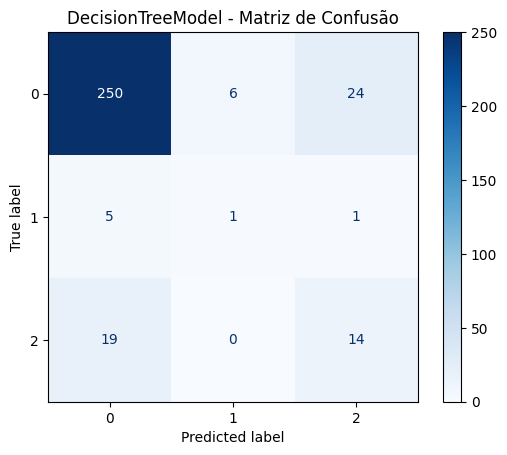


Training and evaluating Naive Bayes...
Acurácia: 61.88%
Precisão: 85.52%
F1 Score: 70.13%


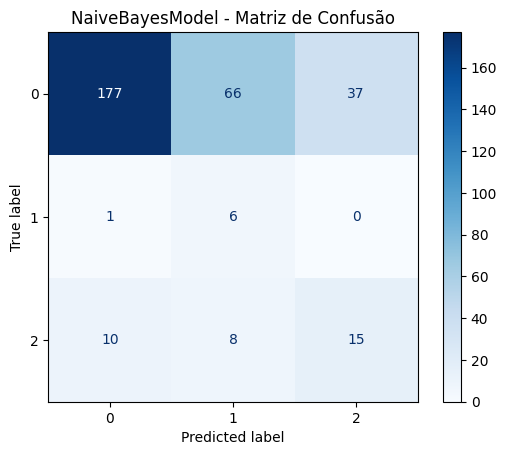


Training and evaluating SVM...
Acurácia: 87.50%
Precisão: 76.56%
F1 Score: 81.67%


/home/franchzin/college/mao-amiga-ia/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


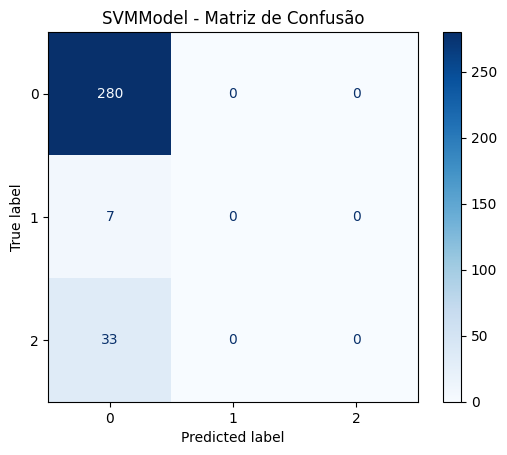

In [15]:
from model.decision_tree_model import DecisionTreeModel
from model.naive_bayes_model import NaiveBayesModel
from model.svm_model import SVMModel
from sklearn.preprocessing import LabelEncoder
import pandas as pd

dataset_path = projects_path
data = pd.read_csv(dataset_path, sep=";", dtype=str)

data['Valor Total (R$)'] = pd.to_numeric(data['Valor Total (R$)']).fillna(0)

bins = [-1, 20000, 100000, float('inf')]
labels = ['Baixo', 'Médio', 'Alto']
data['Valor Total Categoria'] = pd.cut(data['Valor Total (R$)'], bins=bins, labels=labels)

for column in data.select_dtypes(include=['object']).columns:
    if column != 'Valor Total Categoria':
        data[column] = LabelEncoder().fit_transform(data[column])

X = data.drop(['Valor Total (R$)', 'Valor Total Categoria', 'Nome', 'ID Projeto', 'CNPJ OSC', 'Descrição', 'Data de Início', 'Data de Término', 'Status'], axis=1).fillna(0)
y = data['Valor Total Categoria'].fillna('Baixo')

models = {
    'Decision Tree': DecisionTreeModel(),
    'Naive Bayes': NaiveBayesModel(),
    'SVM': SVMModel()
}

for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    model.X, model.y = X, y
    model.train()
    model.evaluate()


## 5. Utilizando a funcionalidade de RBC
Nessa etapa é possível tentar utilizar a funcionalidade de RBC para tentar prever o valor total da próxima ONG por meio de suas características em relação às outras

In [ ]:
from model.case_base_reasoning_model import CaseBasedReasoning
from data.processing.projects import projects_dataset
from pandas import read_csv

projects_source = read_csv(parsed_projects_source, sep=";", dtype=str)
projects_df = projects_dataset(projects_source, osc_df)

from model.case_base_reasoning_model import CaseBasedReasoning
from pandas import read_csv

merged_df = projects_df.merge( osc_df, left_on='CNPJ OSC', right_on='CNPJ', how='left' )

rbc_df = merged_df[[
    'Áreas de Atuação',
    'UF',
    'Município',
    'Valor Total (R$)',
]].dropna()

rbc = CaseBasedReasoning(
    data=rbc_df,
    categorical_cols=['Áreas de Atuação', 'UF', 'Município'],
    numeric_cols=['Valor Total (R$)'],
    target_col='Valor Total (R$)'
)

rbc.preprocess()

new_case = {
    'Áreas de Atuação': 'Educação',
    'UF': 'SP',
    'Município': 'São Paulo',
    'Valor Total (R$)': 75000
}

predicted_value, similar_cases_df = rbc.predict(new_case, k=3)

print(f"\nPredicted Value Total (R$): {predicted_value:.2f}")
print("\nMost similar cases:")
display(similar_cases_df)



KeyError: "['Id Projeto'] not in index"